# Support Vector Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('./dados/dados.csv') #Lendo os dados

df.head()

,Data e Hora,Hora,Mês,Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Ins. (C),...,Pto Orvalho Min. (C),Pressao Ins. (hPa),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Radiacao (KJ/m²),Chuva (mm),Potência CA (W)
0,2019-01-06 06:00:00,6,1,23.2,23.7,23.2,89.0,89.0,89.0,21.4,...,21.4,982.4,982.5,982.1,3.8,224.0,5.5,2.8,0.0,143.583333
1,2019-01-06 07:00:00,7,1,24.0,24.0,23.2,89.0,89.0,89.0,22.1,...,21.4,983.3,983.3,982.3,4.0,224.0,6.8,314.2,0.0,385.333333
2,2019-01-06 08:00:00,8,1,25.9,25.9,24.0,86.0,89.0,86.0,23.3,...,22.1,983.8,983.8,983.3,4.0,215.0,6.5,1204.2,0.0,674.916667
3,2019-01-06 09:00:00,9,1,27.2,27.3,25.9,82.0,86.0,82.0,24.0,...,23.3,984.1,984.1,983.8,3.9,189.0,6.7,1621.1,0.0,1116.166667
4,2019-01-06 10:00:00,10,1,27.9,28.1,27.2,78.0,83.0,78.0,23.7,...,23.7,984.4,984.5,984.1,4.8,165.0,8.5,1464.0,0.0,1715.916667


In [39]:
#Declarando as variáveis:
X = df[['Radiacao (KJ/m²)', 'Temp. Ins. (C)', 'Umi. Ins. (%)', 'Chuva (mm)', 'Hora', 'Mês', 'Pto Orvalho Ins. (C)', 'Temp. Max. (C)',
       'Temp. Min. (C)']]

y = df['Potência CA (W)']


#Separando em treino e teste:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=101) #10% dos dados são p/ teste

# Validação Cruzada

In [40]:
#Criando o modelo:
reg = SVR(C=40, epsilon=0.1)

#Criando a pipeline do modelo:
pipeline = Pipeline([
                    ('scaler', StandardScaler()), ('modelo', reg)                      
                    ])


y_t_log = np.log(y_t) #Transformação log no y

#Declarando a Validação Cruzada:
cross_validation = KFold(n_splits=4, shuffle=True, random_state=101)

#Rodando a Validação Cruzada e calculando o RMSE
cross_val_score(pipeline, X_t, y_t_log, cv=cross_validation, scoring='neg_root_mean_squared_error')
print('RMSE:', cross_val_score(pipeline, X_t, y_t_log, cv=cross_validation, scoring='neg_root_mean_squared_error').mean())

RMSE: -0.5792859204114678


## Obtendo as métricas para os hiperparâmetros escolhidos

In [41]:
#Separando em treino e validação:
X_train, X_valid, y_log_train, y_log_valid = train_test_split(X_t, y_t_log, test_size=0.3, random_state=101)


#Treinando o modelo:
pipeline.fit(X_train, y_log_train)
pred_log = pipeline.predict(X_valid)

#Desfazendo a transformação log
pred = np.exp(pred_log)
y_valid = np.exp(y_log_valid)

#Métricas de avalidação
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, pred)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_valid, pred))
print('R²:', metrics.r2_score(y_valid, pred))

RMSE: 336.4889451184345
MAPE: 0.7049459249868366
R²: 0.8448620632132322


# Prevendo os dados de teste

In [42]:
#Normalizando os dados de entrada:
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_test_scaled = scaler.fit_transform(X_test)

y_t_log = np.log(y_t) #Aplicando transformação log nos dados de saída

#Treinando o modelo:
reg.fit(X_t_scaled, y_t_log)

#Fazendo a previsão:
pred_log = reg.predict(X_test_scaled)


pred = np.exp(pred_log)


#Avaliando o modelo:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, pred))
print('R²:', metrics.r2_score(y_test, pred))

RMSE: 319.94637738576284
MAPE: 0.6826095890682616
R²: 0.856091316010335


<AxesSubplot:xlabel='Valor Real', ylabel='Previsão'>

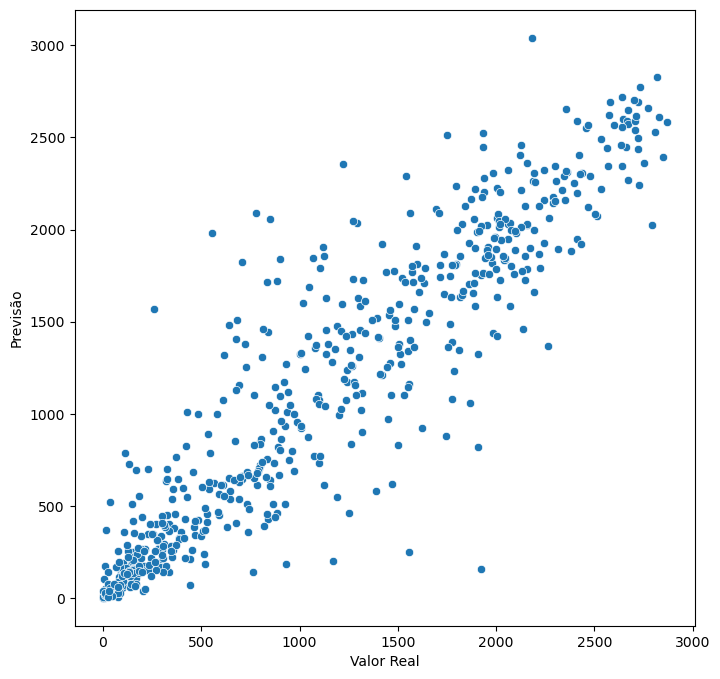

In [43]:
plt.figure(figsize=(8,8))
plt.xlabel('Valor Real')
plt.ylabel('Previsão')
sns.scatterplot(y_test,pred)

In [44]:
pred_table = pd.DataFrame({'Real': y_test, 'Previsto': pred, 'Erro': pred-y_test})

pred_table.head()

,Real,Previsto,Erro
2989,1298.800000,1631.105663,332.305663
3644,2411.333333,1950.552753,-460.780581
3296,2173.416667,1898.583027,-274.833640
96,1222.000000,2354.844746,1132.844746
1884,1922.750000,1752.205274,-170.544726


In [57]:
np.sqrt(metrics.mean_squared_error(y_test, pred))/max(y_test)

0.11593712092879883

In [45]:
np.sqrt(metrics.mean_squared_error(y_test, pred))/(df['Potência CA (W)']).mean()

0.29660076362628063

In [47]:
len(pred)

2.4442

606